<a href="https://colab.research.google.com/github/anpaschool/deep-learning/blob/master/notebooks/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network: Callback and Checkpoints

For classifying MNIST digits. 

_Remember to change your Runtime to GPU or TPU._

#### Load dependencies

In [1]:
#pip install tensorflow==2.0.0-beta0
#pip install --upgrade tensorflow==2.0.0-beta0

In [2]:
import tensorflow as tf
from tensorflow import keras  # tf.keras
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import time

In [3]:
sns.set()
%matplotlib inline
%load_ext tensorboard

In [4]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
tensorflow 2.0.0-beta0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


#### Load data

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = (
    fashion_mnist.load_data())
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
#X_train[0]

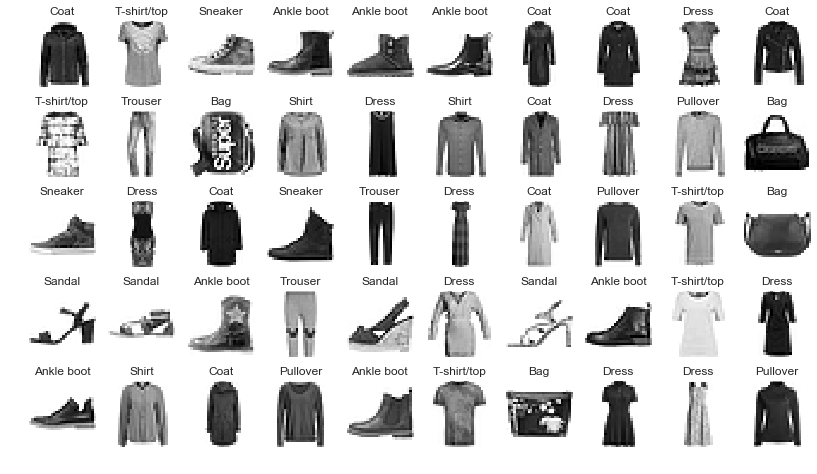

In [9]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [10]:
y_train[0:50]

array([4, 0, 7, 9, 9, 9, 4, 4, 3, 4, 0, 1, 8, 6, 3, 6, 4, 3, 2, 8, 7, 3,
       4, 7, 1, 3, 4, 2, 0, 8, 5, 5, 9, 1, 5, 3, 5, 9, 0, 3, 9, 6, 4, 2,
       9, 0, 8, 3, 3, 2], dtype=uint8)

In [11]:
class_names[y_train[0]]

'Coat'

### Preprocess data : Feature Scaling

When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

**Tips**:
* For each feature (pixel intensity), you must subtract the `mean()` of that feature (across all instances, so use `axis=0`) and divide by its standard deviation (`std()`, again `axis=0`). Alternatively, you can use Scikit-Learn's `StandardScaler`.
* Make sure you compute the means and standard deviations on the training set, and use these statistics to scale the training set, the validation set and the test set (you should not fit the validation set or the test set, and computing the means and standard deviations counts as "fitting").

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32)\
                                      .reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32)\
                                  .reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32)\
                                 .reshape(-1, 28 * 28)).reshape(-1, 28, 28)

#### Design neural network architecture

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Configure model: Callbacks and Checkpoints

The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(1e-3),\
              metrics=["accuracy"])

#### Train!

In [24]:
mkdir log

mkdir: log: File exists


In [25]:
logdir = os.path.join("./log/run_1", "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

In [26]:
history = model.fit(X_train_scaled,\
                    y_train,\
                    batch_size=128,\
                    epochs=20,
                    validation_data=(X_valid_scaled, y_valid),
                   callbacks=callbacks)

W1228 16:58:45.364671 4328199616 deprecation.py:323] From /Users/admin/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 2s 40us/sample - loss: 1.4332 - accuracy: 0.5387 - val_loss: 0.9500 - val_accuracy: 0.7058
Epoch 2/20
55000/55000 [==============================] - 2s 28us/sample - loss: 0.8561 - accuracy: 0.7255 - val_loss: 0.7478 - val_accuracy: 0.7598
Epoch 3/20
55000/55000 [==============================] - 2s 28us/sample - loss: 0.7228 - accuracy: 0.7617 - val_loss: 0.6602 - val_accuracy: 0.7816
Epoch 4/20
55000/55000 [==============================] - 2s 32us/sample - loss: 0.6535 - accuracy: 0.7809 - val_loss: 0.6091 - val_accuracy: 0.7990
Epoch 5/20
55000/55000 [==============================] - 2s 35us/sample - loss: 0.6085 - accuracy: 0.7931 - val_loss: 0.5736 - val_accuracy: 0.8116
Epoch 6/20
55000/55000 [==============================] - 2s 31us/sample - loss: 0.5760 - accuracy: 0.8018 - val_loss: 0.5479 - val_accuracy: 0.8172
Epoch 7/20
55000/55000 [==============================] -

In [116]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.4680 - accuracy: 0.8349


[0.4679875907897949, 0.8349]

In [27]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

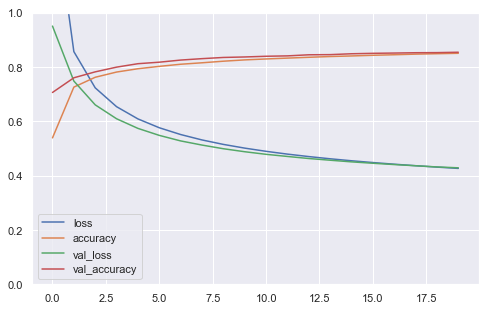

In [28]:
plot_learning_curves(history)

The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [29]:
model = keras.models.load_model("my_mnist_model.h5")

In [30]:
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 41us/sample - loss: 0.4286 - accuracy: 0.8538


[0.428587375164032, 0.8538]

#### Performing Inference

In [31]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 38us/sample - loss: 6.0076 - accuracy: 0.6082


[6.007626473999023, 0.6082]

In [32]:
X_valid.shape

(5000, 28, 28)

In [33]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ]],
      dtype=float32)

In [34]:
y_pred = model.predict_classes(X_new)
y_pred

array([8, 2, 1, 1, 2, 1, 4, 4, 8, 8])

In [35]:
for item in y_pred:
    print(class_names[item])

Bag
Pullover
Trouser
Trouser
Pullover
Trouser
Coat
Coat
Bag
Bag


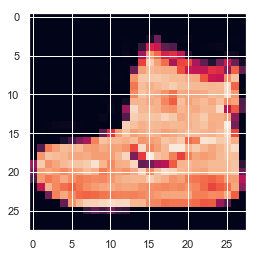

In [38]:
plt.imshow(X_valid[0].reshape(28,28))